In [ ]:
# !pip3 install toolz

In [ ]:
!which python

In [1]:
from tqdm import tqdm
import pandas as pd
import toolz
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import numpy as np

In [36]:
torch.cuda.is_available()

True

# Embed

In [108]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ['query: how much protein should a female eat',
               'query: 南瓜的家常做法',
               "passage: As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
               "passage: 1.清炒南瓜丝 原料:嫩南瓜半个 调料:葱、盐、白糖、鸡精 做法: 1、南瓜用刀薄薄的削去表面一层皮,用勺子刮去瓤 2、擦成细丝(没有擦菜板就用刀慢慢切成细丝) 3、锅烧热放油,入葱花煸出香味 4、入南瓜丝快速翻炒一分钟左右,放盐、一点白糖和鸡精调味出锅 2.香葱炒南瓜 原料:南瓜1只 调料:香葱、蒜末、橄榄油、盐 做法: 1、将南瓜去皮,切成片 2、油锅8成热后,将蒜末放入爆香 3、爆香后,将南瓜片放入,翻炒 4、在翻炒的同时,可以不时地往锅里加水,但不要太多 5、放入盐,炒匀 6、南瓜差不多软和绵了之后,就可以关火 7、撒入香葱,即可出锅"]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
# model = torch.nn.DataParallel(AutoModel.from_pretrained('intfloat/multilingual-e5-small', device_map="cuda"))
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small', device_map="cuda")




In [ ]:
# # Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
batch_dict = {k: v.to('cuda') for k, v in batch_dict.items()}

model.eval()
outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
# # normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())


In [ ]:
embeddings

In [ ]:
embeddings.shape

In [109]:
def process_emb(batch):
    batch_dict = tokenizer(batch, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict = {k: v.to('cuda') for k, v in batch_dict.items()}
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.to('cpu').detach()

In [ ]:
model.eval()
all_embs = []
with tqdm() as pbar:
    with open('distill_corpus/sample.en') as f:
        for part in toolz.partition_all(64000, f):
            maxi_batch = [f'query: {sent.rstrip()}' for sent in part]
            for mini_batch in toolz.partition_all(32, maxi_batch):
                emb = process_emb(mini_batch)
                all_embs.append(emb)
                pbar.update(len(mini_batch))

In [ ]:
all_embeddings = torch.cat(all_embs, dim=0)
save_path = f"distill_corpus/sample/embeddings.pt"
torch.save(all_embeddings, save_path)

# Cluster

In [141]:
embs = torch.cat([torch.load(f'distill_corpus/sample/part_{i}_embeddings.pt') for i in range(8)])

In [142]:
embs.shape

torch.Size([178112, 384])

In [3]:
embs = embs.numpy()

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=5000,
                         random_state=0,
                         batch_size=256*56,
                         n_init="auto")

kmeans = kmeans.fit(embs)

In [ ]:
centroids = kmeans.cluster_centers_
centroids.shape

In [ ]:
with open('distill_corpus/centroids_5k.npy', 'wb') as f:
    np.save(f, centroids)

In [ ]:
# run torchrun --nproc_per_node=8 cluster_corpus_ddp.py

In [3]:
clusters = np.concatenate([np.load(f'distill_corpus/corpus/corpus_{i}_clusters.npy') for i in range(8)])
clusters.shape

(376442118,)

In [42]:
# we should either use normalized embeddings and cosine similarity which requries normalizing centroids or a more standard scikit-learn k-means euclidian distance which requires non-normalized everything
# dot-product is more traditional in NN search for embeddings and it's fast on GPU
centroids_norm = centroids / np.linalg.norm(centroids, axis=1, keepdims=True)
centroids_tensor = torch.from_numpy(centroids_norm).cuda()
def process_cluster(batch):
    batch_dict = tokenizer(batch, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict = {k: v.cuda() for k, v in batch_dict.items()}
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    scores = (embeddings @ centroids_tensor.T)
    clusters = np.argmax(scores.to('cpu').detach().numpy(), axis=1)
    return clusters
cl_proc = process_cluster(input_texts)
cl_proc

array([4592, 3772, 4706, 4784])

In [43]:
cl_proc.shape

(4,)

# inspect clusters

In [3]:
clusters = np.load(f'distill_corpus/sample/part_0_clusters.npy')[:64000]

In [8]:
embs = torch.load(f'distill_corpus/sample/part_0_embeddings.pt')[:64000]
embs.shape

torch.Size([22912, 384])

In [60]:
pd.DataFrame(embs[:64000]).to_csv('distill_corpus/part_0_embeddings_64k.tsv', sep='\t', index=False, header=False)

In [4]:
with open('distill_corpus/centroids/centroids_5k.npy', 'rb') as f:
    centroids = np.load(f)
    centroids_norm = centroids / np.linalg.norm(centroids, axis=1, keepdims=True)
 

In [5]:
centroids_norm.shape

(5000, 384)

In [10]:
scores = (embs @ centroids_norm.T)

In [11]:
scores.shape

torch.Size([22912, 5000])

In [12]:
clusters = np.argmax(scores, axis=1)

In [13]:
def get_clusters(embs):
    scores = (embs @ centroids_norm.T)
    clusters = np.argmax(scores, axis=1)
    return clusters.tolist()

In [19]:
with open('distill_corpus/sample/sample.en') as f:
    texts = f.read()
df_64 = pd.DataFrame({'text': list(texts.strip().split('\n'))})
df_64.describe()

,text
count,10000000
unique,9996805
top,Requested URL: /Customer/SearchDetails.aspx
freq,3


In [20]:
df_64['cluster'] = clusters

In [31]:
df_64['cluster'].unique().size

4999

In [23]:
df_64

,text,cluster
0,Cristiano Ronaldo celebrates as Madid take the...,939
1,"As a result, the Ombudsman closed dSL's pendin...",3427
2,"Rwanda has closed schools in the capital, Kiga...",1737
3,"So ""Long Tall Sally.""",1775
4,"Tolls would depend on the day of the week, hou...",929
...,...,...
9999995,"""Oh, I guess,"" he sighs.",2621
9999996,"Just ask Tiffany ""Thi"" Nguyen, a senior at Rai...",1515
9999997,The U.S. Environmental Protection Agency (EPA)...,4638
9999998,"""Yes,"" answered Sara, and suddenly a strange t...",4980


<Axes: >

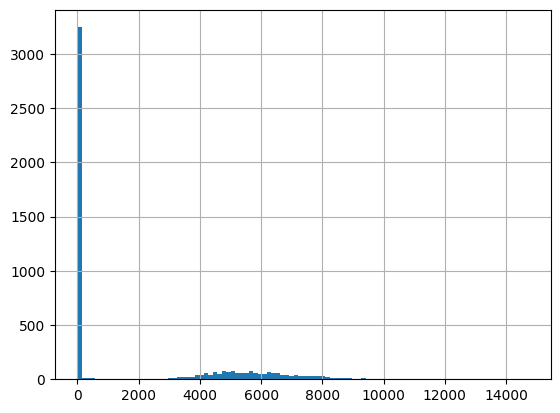

In [25]:
sizes = df_64.groupby('cluster').size()
sizes.hist(bins=100)

In [22]:
sizes.describe(percentiles=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

count     4999.000000
mean      2000.400080
std       2910.977144
min          1.000000
1%           1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          2.000000
50%          3.000000
60%         10.000000
70%       4105.600000
80%       5338.400000
90%       6577.600000
95%       7567.500000
99%       8986.620000
max      14725.000000
dtype: float64

In [28]:
i = 0
for group, texts in df_64.groupby('cluster'):

    if len(texts) < 10:
        continue
    print(group)
    print(f'size: {len(texts)}')
    for text in texts['text'].sample(10).tolist():
        print(text)
    print('=================================================================')
    i+=1
    if i == 50:
        break

4
size: 6636
A/61/277 Item 52 (b) of the provisional agenda - - Sustainable development: follow-up and implementation of the Mauritius Strategy for the Further Implementation of the Programme of Action for the Sustainable Development of Small Island Developing States - - Report of the Secretary-General [A C E F R S]
The Secretary-General thus submits to the Fifth Committee for its consideration the list of candidates nominated for membership in the International Civil Service Commission for a four-year term of office beginning 1 January 2002:
2. In its resolution 2002/26 of 24 July 2002 entitled " Further promotion of equalization of opportunities by, for and with persons with disabilities and protection of their human rights " , the Economic and Social Council requested the Secretary-General to seek the views of Member States on the proposals contained in the report of the Special Rapporteur, especially on the suggested supplement to the Standard Rules, and to submit a substantive rep

# Sample

In [5]:
all_clusters = np.concatenate([np.load(f'distill_corpus/corpus/corpus_{i}_clusters.npy') for i in range(8)])
all_clusters.shape

(376442118,)

In [38]:
all_clusters.shape

(376442118,)

In [7]:
clusters_series = pd.Series(all_clusters)
clusters_series.describe()

count    3.764421e+08
mean     2.168373e+03
std      1.383804e+03
min      0.000000e+00
25%      9.490000e+02
50%      2.045000e+03
75%      3.253000e+03
max      4.999000e+03
dtype: float64

In [8]:
clusters_series.info()

<class 'pandas.core.series.Series'>
RangeIndex: 376442118 entries, 0 to 376442117
Series name: None
Non-Null Count      Dtype
--------------      -----
376442118 non-null  int64
dtypes: int64(1)
memory usage: 2.8 GB


In [9]:
clusters_series.unique().shape

(4999,)

In [10]:
clusters_series.head()

0    3118
1    1128
2    1562
3    4653
4    3383
dtype: int64

In [11]:
(clusters_series == -1).sum()

0

In [12]:
import random
from collections import deque

In [13]:
num_clusters = 5000

In [14]:
cluster_lists = [deque() for _ in range(num_clusters)]
len(cluster_lists)

5000

In [15]:
for line_id, cluster in enumerate(all_clusters):
    if cluster != -1:
        cluster_lists[cluster].append(line_id)

In [ ]:
# for cluster_list in cluster_lists:
#     random.shuffle(cluster_list)

In [16]:
for sample_size, name in ((1000000, '1M'), (10000000, '10M'), (50000000, '50M')):
    sample = deque()
    while len(sample) < sample_size:
        for cluster_list in cluster_lists:
            if cluster_list:
                sample.append(cluster_list.pop())
                if len(sample) == sample_size:
                    break
    sample = list(sample)
    print(f'sampled {len(sample)}')
    np.save(f'distill_corpus/diverse_sample/diverse_sample.en_{name}.npy', np.array(sample))


sampled 1000000
sampled 10000000
sampled 50000000


In [22]:
names = ('1M', '10M', '50M')
ids = {name: set(np.load(f'distill_corpus/diverse_sample/diverse_sample.en_{name}.npy')) for name in names}

with open('distill_corpus/corpus/corpus.en') as f_read:
    with open(f'distill_corpus/diverse_sample/diverse_sample.1M.en', 'w') as f_out_1m:
        with open(f'distill_corpus/diverse_sample/diverse_sample.10M.en', 'w') as f_out_10m:
            with open(f'distill_corpus/diverse_sample/diverse_sample.50M.en', 'w') as f_out_50m:
                f_out = {'1M': f_out_1m, '10M': f_out_10m, '50M': f_out_50m}
                for line_num, text in tqdm(enumerate(f_read)):
                    for name in names:
                        if line_num in ids[name]:
                            f_out[name].write(f'{text}')

376442118it [08:31, 735696.37it/s]


# Inspect sample

In [23]:
ids_1m = np.load(f'distill_corpus/diverse_sample/diverse_sample.en_1M.npy')
ids_10m = np.load(f'distill_corpus/diverse_sample/diverse_sample.en_10M.npy')


In [24]:
ids_1m[:10]

array([362812100, 370452467, 358591923, 164010577, 376436821, 356724467,
       376080692, 131676184, 244940423, 376141511])

In [25]:
ids_10m[:10]

array([376371916,  25552336, 366769996, 343269954, 376192114, 375800616,
       367137089, 267996840, 374090104, 362141792])

In [32]:
with open('distill_corpus/diverse_sample/diverse_sample.1M.en') as f:
    sample = f.readlines()

In [45]:
sample[:100]

['New York has become the 16th state to legalize cannabisCredit: Getty\n',
 'Amazon Fire TV owners receive FREE upgrade\n',
 'Gemma Collins looks slimmer than ever as she gives fans hair envy in glam snap\n',
 'Isaacson Point\n',
 'Miami-Dade mayor Daniella Levine Cava approved the demolitionCredit: Getty\n',
 "Nigeria Chibok girls' shown alive 'in Boko Haram video\n",
 'Half back raising taxes to support the NHS.\n',
 'He hit .305 last season.\n',
 'Requirement before usage\n',
 'Archbishop of Canterbury to condemn Illegal Migration Bill in Lords - reports\n',
 '23.2 overs (0 Run) Angling in, on a good length, outside off, the ball straightens a bit after pitching.\n',
 'The Millennium Falcon\n',
 'So then give us some context then.\n',
 'The internal temperature in which the meat is being grilled is shown through the temperature gauge and with precision. Smaller the chamber, more accurately will the thermometer show the internal conditions.\n',
 'Paying Attention – Receipts?\n',
 '/ 

In [55]:
sample_df = pd.DataFrame([{'text': text, 'cluster': all_clusters[id], 'len': len(text), 'words': len(text.split())} for text, id in zip(sample, ids_1m)])

sample_df

,text,cluster,len,words
0,New York has become the 16th state to legalize...,0,69,11
1,Amazon Fire TV owners receive FREE upgrade\n,1,43,7
2,Gemma Collins looks slimmer than ever as she g...,2,79,15
3,Isaacson Point\n,3,15,2
4,Miami-Dade mayor Daniella Levine Cava approved...,4,75,9
...,...,...,...,...
999995,"1 Alfred Terrace, Glasgow, United Kingdom (Sho...",316,54,9
999996,"Excel East, London, United Kingdom (Show map )\n",317,47,8
999997,"Via Pavia 3, Milan, Italy (Show map )\n",318,38,8
999998,"Timbermills, Dublin, Ireland (Show map )\n",323,41,6


<Axes: >

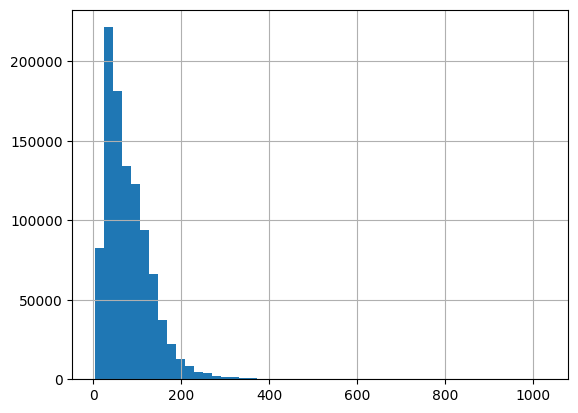

In [56]:
sample_df.len.hist(bins=50)

<Axes: >

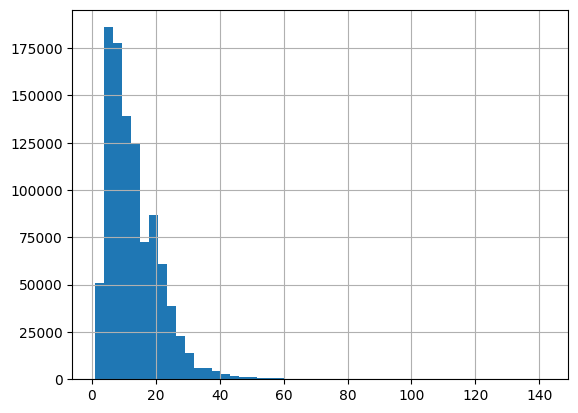

In [58]:
sample_df.words.hist(bins=50)

In [57]:
sizes = sample_df.groupby('cluster').size()
sizes.describe(percentiles=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

count    4999.000000
mean      200.040008
std       202.272846
min         1.000000
1%          1.000000
5%          1.000000
10%         2.000000
20%         4.600000
30%        11.000000
40%        28.000000
50%        80.000000
60%       325.000000
70%       442.000000
80%       442.000000
90%       442.000000
95%       442.000000
99%       443.000000
max       443.000000
dtype: float64

<Axes: >

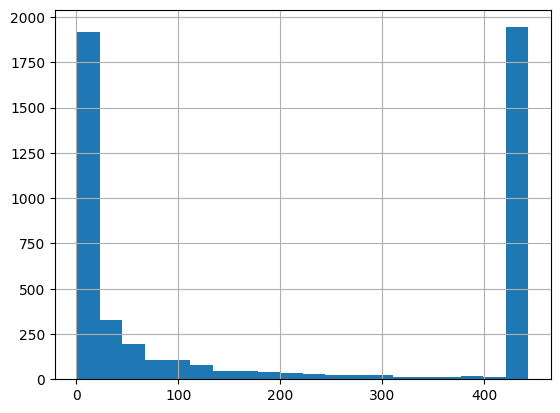

In [61]:
sample_df.groupby('cluster').size().hist(bins=20)